# Sentence-Level Categorization on TREC Dataset

In [26]:
#--- Imports ---#

# Setting Random Seed.
import random
import tensorflow as tf

# Downloading word2vec embeddings.
import os
import gensim.downloader

# Data Preprocessing.
import numpy  as np
import pandas as pd
from sklearn.model_selection  import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Model Architecture.
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, \
                         BatchNormalization, Dropout, \
                         GlobalMaxPooling1D, GlobalAveragePooling1D, Dense
from keras.utils import plot_model

# Model Training.
from time import time
from keras.callbacks import Callback, LearningRateScheduler, EarlyStopping

# Data Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#--- Set Random Seed ---#

WORD = "meow"
seed = sum(ord(char) for char in WORD)

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
#--- Constants ---#

RAND_STATE = seed   # Random State.
VAL_SIZE   = 500    # Size of Validation Dataset.

EMBED_DIM  = 300    # Embedding Dimensions of Pretrained Embedding Model.
LSTM_CELLS = 256    # Number of LSTM cells for LSTM layer.
DROPOUT    = 0.5    # Dropout Rate for Dropout Layer.
DENSE_DIM  = 256    # Dimensions of Dense Layer.

LEARN_RATE = 0.001  # Initial Learning Rate.
LR_DECAY   = 0.95   # Learning Rate Decay.
PATIENCE   = 5      # Early Stopping Patience.
EPOCHS     = 10000  # Number of training epochs.
BATCH_SIZE = 32     # Training Batch Size.

In [29]:
#--- Download word2vec Embeddings ---#

w2v_file_path = "/kaggle/working/word2vec_embeddings.bin" 

if os.path.exists(w2v_file_path):
    # If word2vec embeddings is already downloaded, load from file.
    w2v_vectors = gensim.models.KeyedVectors.load_word2vec_format(w2v_file_path, binary=True)
else:
    # Otherwise download and save word2vec embeddings.
    w2v_vectors = gensim.downloader.load('word2vec-google-news-300')
    w2v_vectors.save_word2vec_format(w2v_file_path, binary=True)

# Data Preprocessing

In [30]:
#--- Read Test Data ---#

df_test = pd.read_csv('/kaggle/input/the-trec-question-classification-dataset-a-longi/test.csv')
df_test

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?
3,0,7,What is an atom ?
4,4,8,When did Hawaii become a state ?
...,...,...,...
495,3,4,Who was the 22nd President of the US ?
496,1,46,What is the money they use in Zambia ?
497,4,13,How many feet in a mile ?
498,1,28,What is the birthstone of October ?


In [31]:
#--- Read Train Data ---#

df_train = pd.read_csv('/kaggle/input/the-trec-question-classification-dataset-a-longi/train.csv')
df_train

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?
...,...,...,...
5447,1,14,What 's the shape of a camel 's spine ?
5448,1,46,What type of currency is used in China ?
5449,4,41,What is the temperature today ?
5450,4,41,What is the temperature for cooking ?


In [32]:
#--- Label Reduction ---#

labels = df_train["label-coarse"].unique() # Get list of labels.

np.random.shuffle(labels) # Get a randomized order of labels.

# Combine the first 2 labels.
df_train.loc[df_train["label-coarse"].isin(labels[:2]), "label-coarse"] = 'OTHERS'
df_test .loc[df_test ["label-coarse"].isin(labels[:2]), "label-coarse"] = 'OTHERS'

labels = df_train["label-coarse"].unique()

#--- Label Mapping ---#

label_map = {} # Map of labels and corresponding index.

for index, label in enumerate(labels): # Map labels to a numerical index.
    label_map[label] = index
    
# Replace labels with corresponding index.
df_train["label-coarse"] = df_train["label-coarse"].replace(label_map)
df_test ["label-coarse"] = df_test ["label-coarse"].replace(label_map)

In [33]:
#--- Print Remaining Classes ---#

print(label_map)

{'OTHERS': 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [34]:
#--- Split Data ---#

X_train, X_val, Y_train, Y_val = train_test_split(df_train['text'],
                                                  df_train['label-coarse'],
                                                  test_size=VAL_SIZE,
                                                  random_state=RAND_STATE)
X_test = df_test['text']
Y_test = df_test['label-coarse']

In [35]:
#--- Tokenization ---#

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_val   = tokenizer.texts_to_sequences(X_val)
X_test  = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

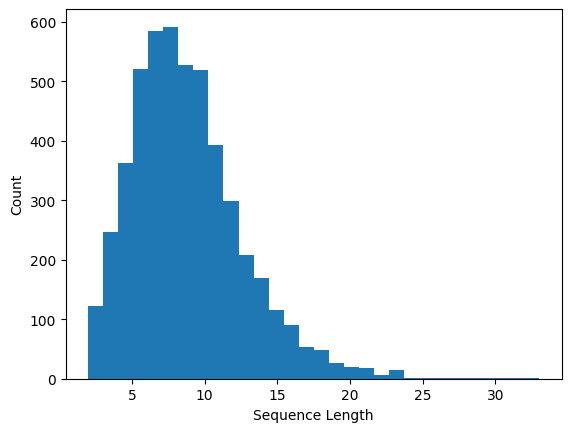

Mean sequence length: 9.115306946688207
Median sequence length: 9.0
Max sequence length: 33
95th percentile sequence length: 16.0


In [36]:
#--- Plot Sequence Lengths ---#

sequence_lengths = [len(seq) for seq in X_train]
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.show()

print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Median sequence length: {np.median(sequence_lengths)}")
print(f"Max sequence length: {max(sequence_lengths)}")
print(f"95th percentile sequence length: {np.percentile(sequence_lengths, 95)}")

In [37]:
#--- Sequence Padding ---#

sequence_length = int(np.percentile(sequence_lengths, 95))

X_train = pad_sequences(X_train, maxlen=sequence_length)
X_val   = pad_sequences(X_val,   maxlen=sequence_length)
X_test  = pad_sequences(X_test,  maxlen=sequence_length)

In [38]:
#--- Convert to float32 array ---#

X_train = np.asarray(X_train).astype('float32')
Y_train = np.asarray(Y_train).astype('float32')
X_val   = np.asarray(X_val)  .astype('float32')
Y_val   = np.asarray(Y_val)  .astype('float32')
X_test  = np.asarray(X_test) .astype('float32')
Y_test  = np.asarray(Y_test) .astype('float32')

# Model Definition

In [39]:
#--- Create Embedding Matrix ---#

embedding_matrix = np.zeros((vocab_size, EMBED_DIM)) # Initialize embedding matrix with zeroes
                                                     # with dimensions `(vocab_size, EMBED_DIM)`.

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        if word in w2v_vectors:
            embedding_matrix[i] = w2v_vectors[word]

In [60]:
EMBED_DIM

300

In [41]:
#--- Model Definition ---#

def create_model(aggregation='max'):

    input_layer       = Input( shape=(sequence_length,) )

    embedding_layer   = Embedding(input_dim=vocab_size,         # Number of words in Vocabulary.
                                  output_dim=EMBED_DIM,         # Embedding Dimension.
                                  input_length=sequence_length, # Sequence Length.
                                  weights=[embedding_matrix],   # Set Pre-trained Weights.
                                  trainable=False,              # Make Embeddings non-trainable.
                                 )(input_layer)

    lstm_layer        = Bidirectional(LSTM( int(LSTM_CELLS*1.0), return_sequences=True ))(embedding_layer)

    dropout_layer     = Dropout(rate=DROPOUT)(lstm_layer)

    if aggregation   == "max":
        pooling_layer = GlobalMaxPooling1D()(dropout_layer)
    elif aggregation == "average":
        pooling_layer = GlobalAveragePooling1D()(dropout_layer)

    dense_layer       = Dense(int(DENSE_DIM*1.0), activation='relu')(pooling_layer)

    output_layer      = Dense(len(labels), activation='softmax')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [47]:
#--- Model Creation ---#

model_maxpool = create_model(aggregation='max')
model_avgpool = create_model(aggregation='average')

plot_model(model_maxpool, 
           to_file='model_maxpool.png', 
           show_shapes=True,
           show_layer_names=True,
           show_layer_activations=True)

model_maxpool.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 16)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 16, 300)           2400600   
                                                                 
 bidirectional_10 (Bidirecti  (None, 16, 512)          1140736   
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 16, 512)           0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 256)               131

# Model Training

In [48]:
#--- Callbacks ---#

#--- Callback Class for Saving Model Weights ---#

class SaveWeights(Callback):
    
    def __init__(self):
        super(SaveWeights, self).__init__()
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        # Get weights of first layer.
        layer_weights = self.model.layers[-1].get_weights() 
        self.weights_history.append(layer_weights)
        
#--- Callback Class for Training Time History ---#

class TimeHistory(Callback):
    
    def on_train_begin(self, logs={}):
        self.time_start = time()        # Track time taken for each epoch.
        self.times = []                 # Track total time taken for training.

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)
        
    def on_train_end(self, logs={}):
        self.time_total = time() - self.time_start
        
#--- Callback Function for Learning Rate Scheduling ---#

def lr_schedule(epoch):
    
    initial_lr = LEARN_RATE                          # Set the initial learning rate.
    learning_rate = initial_lr * (LR_DECAY ** epoch) # Update learning rate with decay.
    
    return learning_rate

In [49]:
#--- Model Training ---#

def train_model(model):

    cb_earlystop    = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, verbose=2)
    cb_saveweights  = SaveWeights()
    cb_timehistory  = TimeHistory()
    cb_lr_scheduler = LearningRateScheduler(lr_schedule)

    callbacks = [cb_earlystop, cb_saveweights, cb_timehistory, cb_lr_scheduler]

    history   = model.fit(X_train, 
                          Y_train, 
                          validation_data=(X_val, Y_val),
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE, 
                          callbacks=callbacks,
                          verbose=2)

    df_results = pd.DataFrame(history.history)

    df_results['epoch'] = history.epoch
    df_results['time']  = cb_timehistory.times

    df_weights = pd.DataFrame(cb_saveweights.weights_history)
    total_time = cb_timehistory.time_total
    
    results = {'results'    : df_results,
               'weights'    : df_weights,
               'total_time' : total_time}
    
    return results

In [54]:
#--- Train Model with MaxPooling ---#

results_maxpool = train_model(model_maxpool)
print(f'Training Time: {results_maxpool["total_time"]}')

#--- Predict using Model with MaxPooling ---#

loss, accuracy = model_maxpool.evaluate(X_test, Y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/10000
155/155 - 1s - loss: 0.1982 - accuracy: 0.9376 - val_loss: 0.3981 - val_accuracy: 0.8560 - lr: 0.0010 - 996ms/epoch - 6ms/step
Epoch 2/10000
155/155 - 1s - loss: 0.1236 - accuracy: 0.9548 - val_loss: 0.3691 - val_accuracy: 0.8840 - lr: 9.5000e-04 - 929ms/epoch - 6ms/step
Epoch 3/10000
155/155 - 1s - loss: 0.0461 - accuracy: 0.9838 - val_loss: 0.3638 - val_accuracy: 0.9000 - lr: 9.0250e-04 - 929ms/epoch - 6ms/step
Epoch 4/10000
155/155 - 1s - loss: 0.0165 - accuracy: 0.9966 - val_loss: 0.4411 - val_accuracy: 0.8920 - lr: 8.5737e-04 - 922ms/epoch - 6ms/step
Epoch 5/10000
155/155 - 1s - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.4575 - val_accuracy: 0.8820 - lr: 8.1451e-04 - 970ms/epoch - 6ms/step
Epoch 6/10000
155/155 - 1s - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.4784 - val_accuracy: 0.8840 - lr: 7.7378e-04 - 922ms/epoch - 6ms/step
Epoch 7/10000
155/155 - 1s - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.4671 - val_accuracy: 0.8900 - lr: 7.3509e-04 - 972ms/epoch 

In [55]:
#--- Train Model with AveragePooling ---#

results_avgpool = train_model(model_avgpool)
print(f'Training Time: {results_avgpool["total_time"]}')

#--- Predict using Model with AveragePooling ---#

loss, accuracy = model_avgpool.evaluate(X_test, Y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Epoch 1/10000
155/155 - 1s - loss: 0.1384 - accuracy: 0.9536 - val_loss: 0.5892 - val_accuracy: 0.8260 - lr: 0.0010 - 989ms/epoch - 6ms/step
Epoch 2/10000
155/155 - 1s - loss: 0.0966 - accuracy: 0.9687 - val_loss: 0.5711 - val_accuracy: 0.8580 - lr: 9.5000e-04 - 923ms/epoch - 6ms/step
Epoch 3/10000
155/155 - 1s - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.7346 - val_accuracy: 0.8540 - lr: 9.0250e-04 - 971ms/epoch - 6ms/step
Epoch 4/10000
155/155 - 1s - loss: 0.0486 - accuracy: 0.9847 - val_loss: 0.7146 - val_accuracy: 0.8480 - lr: 8.5737e-04 - 921ms/epoch - 6ms/step
Epoch 5/10000
155/155 - 1s - loss: 0.0329 - accuracy: 0.9897 - val_loss: 0.8342 - val_accuracy: 0.8460 - lr: 8.1451e-04 - 926ms/epoch - 6ms/step
Epoch 6/10000
155/155 - 1s - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.8251 - val_accuracy: 0.8400 - lr: 7.7378e-04 - 920ms/epoch - 6ms/step
Epoch 7/10000
155/155 - 1s - loss: 0.0255 - accuracy: 0.9921 - val_loss: 0.8056 - val_accuracy: 0.8600 - lr: 7.3509e-04 - 921ms/epoch 

In [56]:
#--- Saving Models ---#

model_maxpool.save('model_maxpool.h5')
model_avgpool.save('model_avgpool.h5')

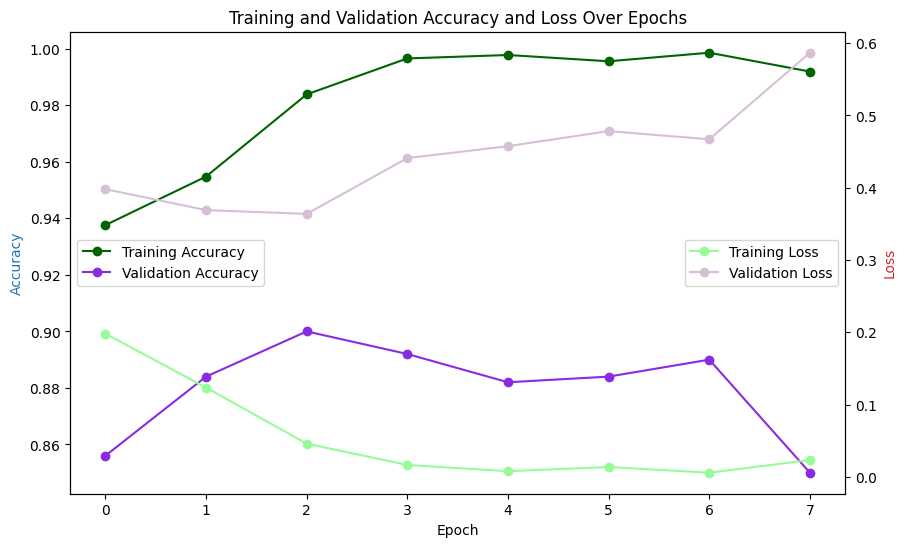

In [77]:
#--- Plot Accuracy ---#

# Create a figure and axes for the accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation accuracy on the first y-axis
ax1.plot(results_maxpool['results']['epoch'], results_maxpool['results']['accuracy'], 
         label='Training Accuracy',   marker='o', color='darkgreen')
ax1.plot(results_maxpool['results']['epoch'], results_maxpool['results']['val_accuracy'], 
         label='Validation Accuracy', marker='o', color='blueviolet')

# Set labels and a legend for the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.legend(loc='center left')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot training and validation loss on the second y-axis
ax2.plot(results_maxpool['results']['epoch'], results_maxpool['results']['loss'], 
         label='Training Loss',   marker='o', color='palegreen')
ax2.plot(results_maxpool['results']['epoch'], results_maxpool['results']['val_loss'], 
         label='Validation Loss', marker='o', color='thistle')

# Set labels and a legend for the second y-axis
ax2.set_ylabel('Loss', color='tab:red')
ax2.legend(loc='center right')

# Title and overall legend
plt.title('Training and Validation Accuracy and Loss Over Epochs')
plt.legend(loc='center right')

# Show the plot
plt.show()